In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import yaml
import omegaconf
import hydra
from hydra import initialize, compose

from framework.unifying_framework import UnifyingFramework
from framework.diffusion.consistency_framework import CMFramework
from framework.diffusion.edm_framework import EDMFramework

from utils import common_utils
from utils.fid_utils import FIDUtils
from utils.fs_utils import FSUtils

from tqdm import tqdm

2023-11-24 01:37:26.321468: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/djfelrl11/diffusion/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# default_path = "/home/djfelrl11/diffusion/configs/config_cm_score.yaml"
config_path = "configs"
# default_path = "config_cm_score"
config_denoiser = "config_denoiser"
config_consistency = "config_consistency"
# config_path = "/home/djfelrl11/diffusion/experiments/0906_verification_unet_block_1/config.yaml"
rng = jax.random.PRNGKey(42)

with initialize(version_base=None, config_path=config_path):
    denoiser_config = compose(config_name=config_denoiser)
    consistency_config = compose(config_name=config_consistency)
denoiser_config["do_training"] = False
consistency_config["do_training"] = False
model_type = denoiser_config.type


# Load the model
# rng, second_rng = jax.random.split(rng)
# diffusion_framework = UnifyingFramework(model_type, denoiser_config, second_rng)

rng, denoiser_rng = jax.random.split(rng, 2)
rng, consistency_rng = jax.random.split(rng, 2)
# denoiser_framework = diffusion_framework.framework
fid_utils = FIDUtils(denoiser_config)
fs_utils = FSUtils(denoiser_config)

denoiser_framework = EDMFramework(denoiser_config, denoiser_rng, fs_utils, None)
consistency_framework = CMFramework(consistency_config, consistency_rng, fs_utils, None)

/home/djfelrl11/diffusion/venv/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config_denoiser': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
/home/djfelrl11/diffusion/venv/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config_consistency': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [3]:
sigma_max = 80
sigma_min = 0.02
rho = 7
n_timestep = denoiser_config.framework.diffusion.n_timestep
sweep_timestep = jnp.arange(n_timestep)

t_steps = (sigma_max ** (1 / rho) + sweep_timestep / (n_timestep - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho

In [4]:
num_sample = 8

datasets = common_utils.load_dataset_from_tfds(n_jitted_steps=1, x_flip=False, batch_size=num_sample)

import os
tmp_saving_dir = "tmp"
if not os.path.exists(tmp_saving_dir):
    os.makedirs(tmp_saving_dir)

sweep_timestep = range(denoiser_config.framework.diffusion.n_timestep)

# for timestep in sweep_timestep:
timestep = 2 # TMP
rng, sampling_rng = jax.random.split(rng)
data = next(datasets)
data = data[0][:, 1, ...]

noise = jax.random.normal(sampling_rng, shape=data.shape)
noise = noise * t_steps[timestep]

# sample = denoiser_framework.sampling(num_sample, original_data=data, sweep_timesteps=timestep)
# sample = denoiser_framework.sampling_denoiser(num_sample, original_data=data, sweep_timesteps=timestep, noise=noise)
sample = consistency_framework.sampling_cm_intermediate(num_sample, original_data=data, sweep_timesteps=timestep, noise=noise)

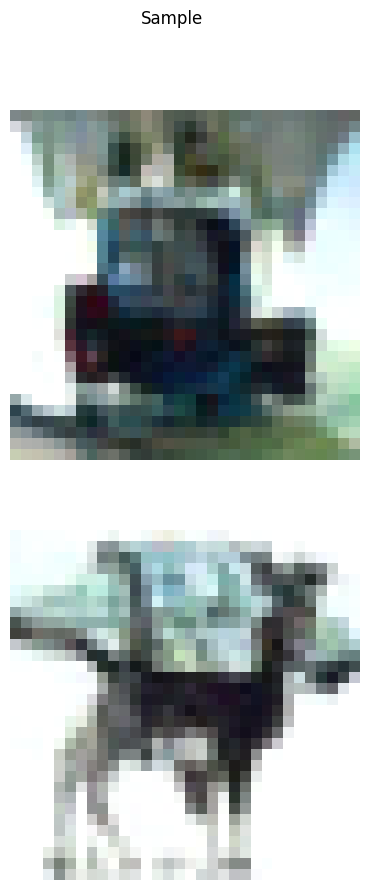

In [5]:
# num_sample_in_
def viz_sample(sample, title="Sample"):
    sample = sample.reshape((sample.shape[0], 32, 32, 3))
    sample = sample[:2]
    
    sample = (sample + 1) / 2
    sample = jnp.clip(sample, 0, 1)

    plt.figure(figsize=(10, 10))
    plt.suptitle(title)
    # for i in range(sample.shape[0]):
    #     plt.subplot(4, 4, i + 1)
    #     plt.imshow(sample[i])
    #     plt.axis("off")
    for i in range(sample.shape[0]):
        plt.subplot(2, 1, i + 1)
        plt.imshow(sample[i])
        plt.axis("off")
    plt.show()
viz_sample(sample)

In [7]:
# The number of multiple datapoints
num_sample = 1000

data = next(datasets)
data = data[0][:, 1, ...] # 8 samples

# tmp_timestep = 60
for timestep in range(0, n_timestep, 6):
# for timestep in range(tmp_timestep, 1, -1):
    # if timestep == 18:
    #     timestep = 17
    timestep = 9
    print(f"Start {timestep} / {n_timestep}")
    
    rng, sampling_rng = jax.random.split(rng)
    noise = jax.random.normal(sampling_rng, shape=data.shape) * t_steps[timestep]
    # noise = jax.random.normal(sampling_rng, shape=data.shape) * timestep

    # Get denoiser output
    denoiser_output = denoiser_framework.sampling_denoiser(num_sample, original_data=data, sweep_timesteps=timestep, noise=noise)

    # Get consistency output
    consistency_output = consistency_framework.sampling_cm_intermediate(num_sample, original_data=data, sweep_timesteps=timestep, noise=noise)

    # Sample multiple datapoints
    sampling_list = []
    num_batch = num_sample // consistency_output.shape[0]
    for i in tqdm(range(num_batch)):
        rng, sampling_rng = jax.random.split(rng)
        new_noise = jax.random.normal(sampling_rng, shape=consistency_output.shape) * t_steps[timestep]
        # new_noise = jax.random.normal(sampling_rng, shape=consistency_output.shape) * timestep

        second_consistency_output = consistency_framework.sampling_cm_intermediate(
            num_sample, original_data=consistency_output, sweep_timesteps=timestep, noise=new_noise)
        sampling_list.append(second_consistency_output)

    # sampling_list = jnp.concatenate(sampling_list, axis=0)
    sampling_list = jnp.stack(sampling_list, axis=0)
    second_consistency_output_empirical_mean = jnp.mean(sampling_list, axis=0)
    # denoiser_output_empirical_mean = jnp.mean(denoiser_output, axis=0)
    error = jnp.mean(jnp.abs(second_consistency_output_empirical_mean - denoiser_output), axis=(-1, -2, -3))
    # error = jnp.mean(jnp.abs(second_consistency_output_empirical_mean - data), axis=(-1, -2, -3))
    # error = jnp.mean(jnp.abs(second_consistency_output_empirical_mean - denoiser_output_empirical_mean))
    print("Error of mean: ", error.flatten())
    print("Total mean of error: ", jnp.mean(error))

    viz_list = jnp.concatenate([denoiser_output[0], second_consistency_output_empirical_mean[0]], axis=0)
    viz_sample(viz_list, title=f"timestep: {timestep}")


Start 9 / 18


  1%|          | 1/125 [00:00<00:52,  2.38it/s]